In [1]:
# 0. 패키지 불러오기
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.utils import np_utils

# 랜덤시드 고정시키기
np.random.seed(5)

# 손실 이력 클래스 정의
class LossHistory(keras.callbacks.Callback):
    def init(self):
        self.losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

# 데이터셋 생성 함수 
def seq2dataset(seq, window_size):
    dataset = []
    for i in range(len(seq)-window_size):
        subset = seq[i:(i+window_size+1)]
        dataset.append([code2idx[item] for item in subset])
    return np.array(dataset)


# 1. 데이터 준비하기

# 코드 사전 정의
code2idx = {'c_oct1_1':0, 'd_oct1_1':1, 'e_oct1_1':2, 'f_oct1_1':3, 'g_oct1_1':4, 'a_oct1_1':5, 'b_oct1_1':6, \
            'c_oct1_2':7, 'd_oct1_2':8, 'e_oct1_2':9, 'f_oct1_2':10, 'g_oct1_2':11, 'a_oct1_2':12, 'b_oct1_2':13, \
            'c_oct1_3':14, 'd_oct1_3':15, 'e_oct1_3':16, 'f_oct1_3':17, 'g_oct1_3':18, 'a_oct1_3':19, 'b_oct1_3':20, \
            'c_oct2_1':21, 'd_oct2_1':22, 'e_oct2_1':23, 'f_oct2_1':24, 'g_oct2_1':25, 'a_oct2_1':26, 'b_oct2_1':27, \
            'c_oct2_2':28, 'd_oct2_2':29, 'e_oct2_2':30, 'f_oct2_2':31, 'g_oct2_2':32, 'a_oct2_2':33, 'b_oct2_2':34, \
            'c_oct2_3':35, 'd_oct2_3':36, 'e_oct2_3':37, 'f_oct2_3':38, 'g_oct2_3':39, 'a_oct2_3':40, 'b_oct2_3':41, \
            'c_oct0_1':42, 'd_oct0_1':43, 'e_oct0_1':44, 'f_oct0_1':45, 'g_oct0_1':46, 'a_oct0_1':47, 'b_oct0_1':48, \
            'c_oct0_2':49, 'd_oct0_2':50, 'e_oct0_2':51, 'f_oct0_2':52, 'g_oct0_2':53, 'a_oct0_2':54, 'b_oct0_2':55, \
            'c_oct0_3':56, 'd_oct0_3':57, 'e_oct0_3':58, 'f_oct0_3':59, 'g_oct0_3':60, 'a_oct0_3':61, 'b_oct0_3':62, \
            'c_oct1_1_legSt':63, 'd_oct1_1_legSt':64, 'e_oct1_1_legSt':65, 'f_oct1_1_legSt':66, 'g_oct1_1_legSt':67, 'a_oct1_1_legSt':68, 'b_oct1_1_legSt':69, \
            'c_oct1_2_legSt':70, 'd_oct1_2_legSt':71, 'e_oct1_2_legSt':72, 'f_oct1_2_legSt':73, 'g_oct1_2_legSt':74, 'a_oct1_2_legSt':75, 'b_oct1_2_legSt':76, \
            'c_oct1_3_legSt':77, 'd_oct1_3_legSt':78, 'e_oct1_3_legSt':79, 'f_oct1_3_legSt':80, 'g_oct1_3_legSt':81, 'a_oct1_3_legSt':82, 'b_oct1_3_legSt':83, \
            'c_oct1_1_legEnd':84, 'd_oct1_1_legEnd':85, 'e_oct1_1_legEnd':86, 'f_oct1_1_legEnd':87, 'g_oct1_1_legEnd':88, 'a_oct1_1_legEnd':89, 'b_oct1_1_legEnd':90, \
            'c_oct1_2_legEnd':91, 'd_oct1_2_legEnd':92, 'e_oct1_2_legEnd':93, 'f_oct1_2_legEnd':94, 'g_oct1_2_legEnd':95, 'a_oct1_2_legEnd':96, 'b_oct1_2_legEnd':97, \
            'c_oct1_3_legEnd':98, 'd_oct1_3_legEnd':99, 'e_oct1_3_legEnd':100, 'f_oct1_3_legEnd':101, 'g_oct1_3_legEnd':102, 'a_oct1_3_legEnd':103, 'b_oct1_3_legEnd':104, \
            'c_oct2_1_legSt':105, 'd_oct2_1_legSt':106, 'e_oct2_1_legSt':107, 'f_oct2_1_legSt':108, 'g_oct2_1_legSt':109, 'a_oct2_1_legSt':110, 'b_oct2_1_legSt':111, \
            'c_oct2_2_legSt':112, 'd_oct2_2_legSt':113, 'e_oct2_2_legSt':114, 'f_oct2_2_legSt':115, 'g_oct2_2_legSt':116, 'a_oct2_2_legSt':117, 'b_oct2_2_legSt':118, \
            'c_oct2_3_legSt':119, 'd_oct2_3_legSt':120, 'e_oct2_3_legSt':121, 'f_oct2_3_legSt':122, 'g_oct2_3_legSt':123, 'a_oct2_3_legSt':124, 'b_oct2_2_legSt':125, \
            'c_oct2_1_legEnd':126, 'd_oct2_1_legEnd':127, 'e_oct2_1_legEnd':128, 'f_oct2_1_legEnd':129, 'g_oct2_1_legEnd':130, 'a_oct2_1_legEnd':131, 'b_oct2_1_legEnd':132, \
            'c_oct2_2_legEnd':133, 'd_oct2_2_legEnd':134, 'e_oct2_2_legEnd':135, 'f_oct2_2_legEnd':136, 'g_oct2_2_legEnd':137, 'a_oct2_2_legEnd':138, 'b_oct2_2_legEnd':139, \
            'c_oct2_3_legEnd':140, 'd_oct2_3_legEnd':141, 'e_oct2_3_legEnd':142, 'f_oct2_3_legEnd':143, 'g_oct2_3_legEnd':144, 'a_oct2_3_legEnd':145, 'b_oct2_3_legEnd':146, \
            'pause_1': 147}

idx2code = {y:x for x,y in code2idx.items()}

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# 시퀀스 데이터 정의
seq = ['a_oct1_3', 'd_oct2_2', 'c_oct2_1', 'b_oct1_2', 'd_oct2_1', 'a_oct1_2_legSt', 'a_oct1_1_legEnd', 'd_oct1_2_legSt', 'e_oct1_1_legEnd', 'f_oct1_2', 'b_oct1_1', 'a_oct1_3_legSt', 'a_oct1_2_legEnd', 'pause_1', 'f_oct1_2_legSt', 'f_oct1_1_legEnd', 'b_oct1_2', 'd_oct2_1', 'a_oct1_2', 'g_oct1_1', 'f_oct1_3', 'g_oct1_2', 'f_oct1_1', 'e_oct1_1', 'b_oct1_1', 'a_oct1_1', 'd_oct1_3_legSt', 'd_oct1_2_legEnd', 'pause_1', 'e_oct1_2_legSt', 'f_oct1_1_legEnd', 'g_oct1_2', 'f_oct1_1', 'e_oct1_1_legSt', 'd_oct1_1_legEnd', 'c_oct1_1', 'b_oct0_3', 'd_oct1_2', 'e_oct1_1', 'f_oct1_2', 'b_oct1_1', 'a_oct1_3_legSt', 'a_oct1_2_legEnd', 'pause_1', 'd_oct2_2_legSt', 'c_oct2_1_legEnd', 'e_oct2_2', 'd_oct2_1', 'c_oct2_1', 'b_oct1_1', 'a_oct1_1', 'f_oct1_3', 'e_oct1_1', 'b_oct1_1', 'a_oct1_1', 'e_oct1_1', 'g_oct1_1', 'f_oct1_1', 'd_oct1_3_legSt', 'd_oct1_2_legEnd', 'pause_1']

# 2. 데이터셋 생성하기
dataset = seq2dataset(seq, window_size = 4)

print(dataset.shape)
print(dataset)

(57, 5)
[[ 19  29  21  13  22]
 [ 29  21  13  22  75]
 [ 21  13  22  75  89]
 [ 13  22  75  89  71]
 [ 22  75  89  71  86]
 [ 75  89  71  86  10]
 [ 89  71  86  10   6]
 [ 71  86  10   6  82]
 [ 86  10   6  82  96]
 [ 10   6  82  96 147]
 [  6  82  96 147  73]
 [ 82  96 147  73  87]
 [ 96 147  73  87  13]
 [147  73  87  13  22]
 [ 73  87  13  22  12]
 [ 87  13  22  12   4]
 [ 13  22  12   4  17]
 [ 22  12   4  17  11]
 [ 12   4  17  11   3]
 [  4  17  11   3   2]
 [ 17  11   3   2   6]
 [ 11   3   2   6   5]
 [  3   2   6   5  78]
 [  2   6   5  78  92]
 [  6   5  78  92 147]
 [  5  78  92 147  72]
 [ 78  92 147  72  87]
 [ 92 147  72  87  11]
 [147  72  87  11   3]
 [ 72  87  11   3  65]
 [ 87  11   3  65  85]
 [ 11   3  65  85   0]
 [  3  65  85   0  62]
 [ 65  85   0  62   8]
 [ 85   0  62   8   2]
 [  0  62   8   2  10]
 [ 62   8   2  10   6]
 [  8   2  10   6  82]
 [  2  10   6  82  96]
 [ 10   6  82  96 147]
 [  6  82  96 147 113]
 [ 82  96 147 113 126]
 [ 96 147 113 126  30]
 [1

In [3]:
# 입력(X)과 출력(Y) 변수로 분리하기
x_train = dataset[:,0:4]
y_train = dataset[:,4]

max_idx_value = 147

# 입력값 정규화 시키기
x_train = x_train / float(max_idx_value)

# 입력을 (샘플 수, 타임스텝, 특성 수)로 형태 변환
x_train = np.reshape(x_train, (57, 4, 1))

# 라벨값에 대한 one-hot 인코딩 수행
y_train = np_utils.to_categorical(y_train)

one_hot_vec_size = y_train.shape[1]

print("one hot encoding vector size is ", one_hot_vec_size)

one hot encoding vector size is  148


epochs : 0
Epoch 1/1
 - 1s - loss: 4.7597 - acc: 0.0175
epochs : 1
Epoch 1/1
 - 1s - loss: 3.7221 - acc: 0.0526
epochs : 2
Epoch 1/1
 - 1s - loss: 3.5260 - acc: 0.1053
epochs : 3
Epoch 1/1
 - 1s - loss: 3.4849 - acc: 0.1053
epochs : 4
Epoch 1/1
 - 1s - loss: 3.4586 - acc: 0.1053
epochs : 5
Epoch 1/1
 - 1s - loss: 3.4395 - acc: 0.1053
epochs : 6
Epoch 1/1
 - 1s - loss: 3.4224 - acc: 0.1053
epochs : 7
Epoch 1/1
 - 1s - loss: 3.4042 - acc: 0.1053
epochs : 8
Epoch 1/1
 - 1s - loss: 3.4117 - acc: 0.0877
epochs : 9
Epoch 1/1
 - 1s - loss: 3.3659 - acc: 0.1053
epochs : 10
Epoch 1/1
 - 1s - loss: 3.3633 - acc: 0.0877
epochs : 11
Epoch 1/1
 - 1s - loss: 3.3883 - acc: 0.0877
epochs : 12
Epoch 1/1
 - 1s - loss: 3.2990 - acc: 0.1404
epochs : 13
Epoch 1/1
 - 1s - loss: 3.2935 - acc: 0.1053
epochs : 14
Epoch 1/1
 - 1s - loss: 3.2452 - acc: 0.0877
epochs : 15
Epoch 1/1
 - 1s - loss: 3.3485 - acc: 0.0526
epochs : 16
Epoch 1/1
 - 1s - loss: 3.2882 - acc: 0.1404
epochs : 17
Epoch 1/1
 - 1s - loss: 2.980

 - 1s - loss: 0.0014 - acc: 1.0000
epochs : 144
Epoch 1/1
 - 1s - loss: 0.0014 - acc: 1.0000
epochs : 145
Epoch 1/1
 - 1s - loss: 0.0013 - acc: 1.0000
epochs : 146
Epoch 1/1
 - 1s - loss: 0.0013 - acc: 1.0000
epochs : 147
Epoch 1/1
 - 1s - loss: 0.0012 - acc: 1.0000
epochs : 148
Epoch 1/1
 - 1s - loss: 0.0012 - acc: 1.0000
epochs : 149
Epoch 1/1
 - 1s - loss: 0.0011 - acc: 1.0000
epochs : 150
Epoch 1/1
 - 1s - loss: 0.0011 - acc: 1.0000
epochs : 151
Epoch 1/1
 - 1s - loss: 0.0011 - acc: 1.0000
epochs : 152
Epoch 1/1
 - 1s - loss: 0.0010 - acc: 1.0000
epochs : 153
Epoch 1/1
 - 1s - loss: 9.8962e-04 - acc: 1.0000
epochs : 154
Epoch 1/1
 - 1s - loss: 9.5654e-04 - acc: 1.0000
epochs : 155
Epoch 1/1
 - 1s - loss: 9.2312e-04 - acc: 1.0000
epochs : 156
Epoch 1/1
 - 1s - loss: 8.9144e-04 - acc: 1.0000
epochs : 157
Epoch 1/1
 - 1s - loss: 8.6066e-04 - acc: 1.0000
epochs : 158
Epoch 1/1
 - 1s - loss: 8.2960e-04 - acc: 1.0000
epochs : 159
Epoch 1/1
 - 1s - loss: 8.0128e-04 - acc: 1.0000
epochs : 

 - 1s - loss: 1.6313e-05 - acc: 1.0000
epochs : 277
Epoch 1/1
 - 1s - loss: 1.5734e-05 - acc: 1.0000
epochs : 278
Epoch 1/1
 - 1s - loss: 1.5311e-05 - acc: 1.0000
epochs : 279
Epoch 1/1
 - 1s - loss: 1.4752e-05 - acc: 1.0000
epochs : 280
Epoch 1/1
 - 1s - loss: 1.4388e-05 - acc: 1.0000
epochs : 281
Epoch 1/1
 - 1s - loss: 1.3906e-05 - acc: 1.0000
epochs : 282
Epoch 1/1
 - 1s - loss: 1.3400e-05 - acc: 1.0000
epochs : 283
Epoch 1/1
 - 1s - loss: 1.3160e-05 - acc: 1.0000
epochs : 284
Epoch 1/1
 - 1s - loss: 1.2703e-05 - acc: 1.0000
epochs : 285
Epoch 1/1
 - 1s - loss: 1.2351e-05 - acc: 1.0000
epochs : 286
Epoch 1/1
 - 1s - loss: 1.1953e-05 - acc: 1.0000
epochs : 287
Epoch 1/1
 - 1s - loss: 1.1591e-05 - acc: 1.0000
epochs : 288
Epoch 1/1
 - 1s - loss: 1.1391e-05 - acc: 1.0000
epochs : 289
Epoch 1/1
 - 1s - loss: 1.0772e-05 - acc: 1.0000
epochs : 290
Epoch 1/1
 - 1s - loss: 1.0602e-05 - acc: 1.0000
epochs : 291
Epoch 1/1
 - 1s - loss: 1.0323e-05 - acc: 1.0000
epochs : 292
Epoch 1/1
 - 1s - 

epochs : 409
Epoch 1/1
 - 1s - loss: 3.2312e-07 - acc: 1.0000
epochs : 410
Epoch 1/1
 - 1s - loss: 3.2626e-07 - acc: 1.0000
epochs : 411
Epoch 1/1
 - 1s - loss: 3.0953e-07 - acc: 1.0000
epochs : 412
Epoch 1/1
 - 1s - loss: 3.0011e-07 - acc: 1.0000
epochs : 413
Epoch 1/1
 - 1s - loss: 3.0116e-07 - acc: 1.0000
epochs : 414
Epoch 1/1
 - 1s - loss: 2.8338e-07 - acc: 1.0000
epochs : 415
Epoch 1/1
 - 1s - loss: 2.7606e-07 - acc: 1.0000
epochs : 416
Epoch 1/1
 - 1s - loss: 2.6979e-07 - acc: 1.0000
epochs : 417
Epoch 1/1
 - 1s - loss: 2.6247e-07 - acc: 1.0000
epochs : 418
Epoch 1/1
 - 1s - loss: 2.5933e-07 - acc: 1.0000
epochs : 419
Epoch 1/1
 - 1s - loss: 2.4888e-07 - acc: 1.0000
epochs : 420
Epoch 1/1
 - 1s - loss: 2.4365e-07 - acc: 1.0000
epochs : 421
Epoch 1/1
 - 1s - loss: 2.3214e-07 - acc: 1.0000
epochs : 422
Epoch 1/1
 - 1s - loss: 2.2587e-07 - acc: 1.0000
epochs : 423
Epoch 1/1
 - 1s - loss: 2.1646e-07 - acc: 1.0000
epochs : 424
Epoch 1/1
 - 1s - loss: 2.1750e-07 - acc: 1.0000
epochs :

 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 542
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 543
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 544
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 545
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 546
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 547
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 548
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 549
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 550
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 551
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 552
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 553
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 554
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 555
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 556
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 557
Epoch 1/1
 - 1s - 

epochs : 674
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 675
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 676
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 677
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 678
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 679
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 680
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 681
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 682
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 683
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 684
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 685
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 686
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 687
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 688
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 689
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs :

 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 807
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 808
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 809
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 810
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 811
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 812
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 813
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 814
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 815
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 816
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 817
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 818
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 819
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 820
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 821
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 822
Epoch 1/1
 - 1s - 

epochs : 939
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 940
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 941
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 942
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 943
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 944
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 945
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 946
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 947
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 948
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 949
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 950
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 951
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 952
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 953
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 954
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs :

 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1071
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1072
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1073
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1074
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1075
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1076
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1077
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1078
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1079
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1080
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1081
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1082
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1083
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1084
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1085
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1086
Ep

epochs : 1201
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1202
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1203
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1204
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1205
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1206
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1207
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1208
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1209
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1210
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1211
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1212
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1213
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1214
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1215
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1216
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc:

 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1332
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1333
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1334
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1335
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1336
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1337
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1338
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1339
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1340
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1341
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1342
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1343
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1344
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1345
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1346
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1347
Ep

epochs : 1462
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1463
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1464
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1465
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1466
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1467
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1468
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1469
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1470
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1471
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1472
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1473
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1474
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1475
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1476
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1477
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc:

 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1593
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1594
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1595
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1596
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1597
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1598
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1599
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1600
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1601
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1602
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1603
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1604
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1605
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1606
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1607
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1608
Ep

epochs : 1723
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1724
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1725
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1726
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1727
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1728
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1729
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1730
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1731
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1732
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1733
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1734
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1735
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1736
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1737
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1738
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc:

 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1854
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1855
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1856
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1857
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1858
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1859
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1860
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1861
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1862
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1863
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1864
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1865
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1866
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1867
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1868
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1869
Ep

epochs : 1984
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1985
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1986
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1987
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1988
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1989
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1990
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1991
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1992
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1993
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1994
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1995
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1996
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1997
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1998
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc: 1.0000
epochs : 1999
Epoch 1/1
 - 1s - loss: 1.1921e-07 - acc:

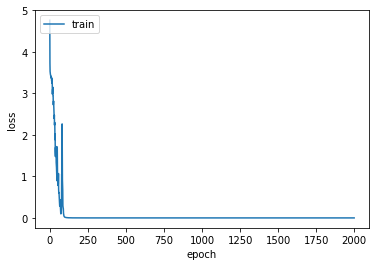

57/57 [==============================] - 0s 3ms/step
acc: 100.00%
one step prediction :  ['a_oct1_3', 'd_oct2_2', 'c_oct2_1', 'b_oct1_2', 'd_oct2_1', 'a_oct1_2_legSt', 'a_oct1_1_legEnd', 'd_oct1_2_legSt', 'e_oct1_1_legEnd', 'f_oct1_2', 'b_oct1_1', 'a_oct1_3_legSt', 'a_oct1_2_legEnd', 'pause_1', 'f_oct1_2_legSt', 'f_oct1_1_legEnd', 'b_oct1_2', 'd_oct2_1', 'a_oct1_2', 'g_oct1_1', 'f_oct1_3', 'g_oct1_2', 'f_oct1_1', 'e_oct1_1', 'b_oct1_1', 'a_oct1_1', 'd_oct1_3_legSt', 'd_oct1_2_legEnd', 'pause_1', 'e_oct1_2_legSt', 'f_oct1_1_legEnd', 'g_oct1_2', 'f_oct1_1', 'e_oct1_1_legSt', 'd_oct1_1_legEnd', 'c_oct1_1', 'b_oct0_3', 'd_oct1_2', 'e_oct1_1', 'f_oct1_2', 'b_oct1_1', 'a_oct1_3_legSt', 'a_oct1_2_legEnd', 'pause_1', 'd_oct2_2_legSt', 'c_oct2_1_legEnd', 'e_oct2_2', 'd_oct2_1', 'c_oct2_1', 'b_oct1_1', 'a_oct1_1', 'f_oct1_3', 'e_oct1_1', 'b_oct1_1', 'a_oct1_1', 'e_oct1_1', 'g_oct1_1', 'f_oct1_1', 'd_oct1_3_legSt', 'd_oct1_2_legEnd', 'pause_1']
full song prediction :  ['a_oct1_3', 'd_oct2_2', 'c_

In [4]:
# 3. 모델 구성하기
model = Sequential()
model.add(LSTM(350, batch_input_shape = (1, 4, 1), stateful=True))
model.add(Dense(one_hot_vec_size, activation='softmax'))


# 4. 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


# 5. 모델 학습시키기
num_epochs = 2000

history = LossHistory() # 손실 이력 객체 생성

history.init()

for epoch_idx in range(num_epochs):
    print ('epochs : ' + str(epoch_idx) )
    model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2, shuffle=False, callbacks=[history]) # 50 is X.shape[0]
    model.reset_states()
    

# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(history.losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()


# 7. 모델 평가하기
scores = model.evaluate(x_train, y_train, batch_size=1)
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))
model.reset_states()


# 8. 모델 사용하기

pred_count = 57 # 최대 예측 개수 정의

# 한 스텝 예측

seq_out = ['a_oct1_3', 'd_oct2_2', 'c_oct2_1', 'b_oct1_2']
pred_out = model.predict(x_train, batch_size=1)

for i in range(pred_count):
    idx = np.argmax(pred_out[i]) # one-hot 인코딩을 인덱스 값으로 변환
    seq_out.append(idx2code[idx]) # seq_out는 최종 악보이므로 인덱스 값을 코드로 변환하여 저장

model.reset_states()
    
print("one step prediction : ", seq_out)

# 곡 전체 예측

seq_in = ['a_oct1_3', 'd_oct2_2', 'c_oct2_1', 'b_oct1_2']
seq_out = seq_in
seq_in = [code2idx[it] / float(max_idx_value) for it in seq_in] # 코드를 인덱스값으로 변환

for i in range(pred_count):
    sample_in = np.array(seq_in)
    sample_in = np.reshape(sample_in, (1, 4, 1)) # 샘플 수, 타입스텝 수, 속성 수
    pred_out = model.predict(sample_in)
    idx = np.argmax(pred_out)
    seq_out.append(idx2code[idx])
    seq_in.append(idx / float(max_idx_value))
    seq_in.pop(0)

model.reset_states()
    
print("full song prediction : ", seq_out)

Result(LSTM_Stateful)
acc: 100.00%


